# TODO
- Normalize features to ensure they contribute equally to the model.
- Use box plots or Z-scores to identify and handle outliers.
- Use Recursive Feature Elimination (RFE) to select significant features.
- Compare multiple models to identify which performs best. Now onlye OLS vs GLM (gamma)
- Explain why {model} over other models.
- Add what the findings mean for stakeholders (e.g., real estate investors, buyers).
- Suggest areas for further research or improvements, such as incorporating more data, exploring additional features, or deploying the model in a real-world setting.
- 



# Introduction

This project aims to develop a robust predictive model for estimating housing prices based on key features like property size, location, and number of rooms. By leveraging statistical analysis and modeling techniques, we explore the relationships between various property characteristics and their impact on market value. The resulting model will serve as a reliable, data-driven valuation tool, providing valuable insights for the real estate industry to estimate property prices with precision

The *Housing Price Prediction*$\text{}^{1}$ dataset observed provides key features for predicting house prices, including area, bedrooms, bathrooms, stories, amenities like air conditioning and parking, and information on furnishing status. It enables analysis and modeling to understand the factors impacting house prices and develop accurate predictions in real estate markets.

This dataset contains the following columns:
- **Price**: The price of the house.
- **Area**: The total area of the house in square feet.
- **Bedrooms**: The number of bedrooms in the house.
- **Bathrooms**: The number of bathrooms in the house.
- **Stories**: The number of stories in the house.
- **Mainroad**: Whether the house is connected to the main road (Yes/No).
- **Guestroom**: Whether the house has a guest room (Yes/No).
- **Basement**: Whether the house has a basement (Yes/No).
- **Hot water heating**: Whether the house has a hot water heating system (Yes/No).
- **Airconditioning**: Whether the house has an air conditioning system (Yes/No).
- **Parking**: The number of parking spaces available within the house.
- **Prefarea**: Whether the house is located in a preferred area (Yes/No).
- **Furnishing status**: The furnishing status of the house (Fully Furnished, Semi-Furnished, Unfurnished).


# Library Imports

In [1]:
# import necessary libraries
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import DomainWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
import warnings


pd.set_option('future.no_silent_downcasting', True)
warnings.filterwarnings('ignore', category=FutureWarning, module='statsmodels.genmod.families.links')
warnings.filterwarnings("ignore", category=DomainWarning)

# Data Loading and Initial Overview

In [2]:
# data import
housing_raw = pd.read_csv('housing.csv')

In [3]:
# dxplore first five items of the data
housing_raw.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
# shape of the data; (rows, columns)
housing_raw.shape

(545, 13)

In [5]:
housing_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [6]:
# statistical description of the data
housing_raw.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


# Data Cleaning and Preparation

In [7]:
# removes any row with at least one missing value
housing = housing_raw.dropna()

#  Exploratory Data Analysis 

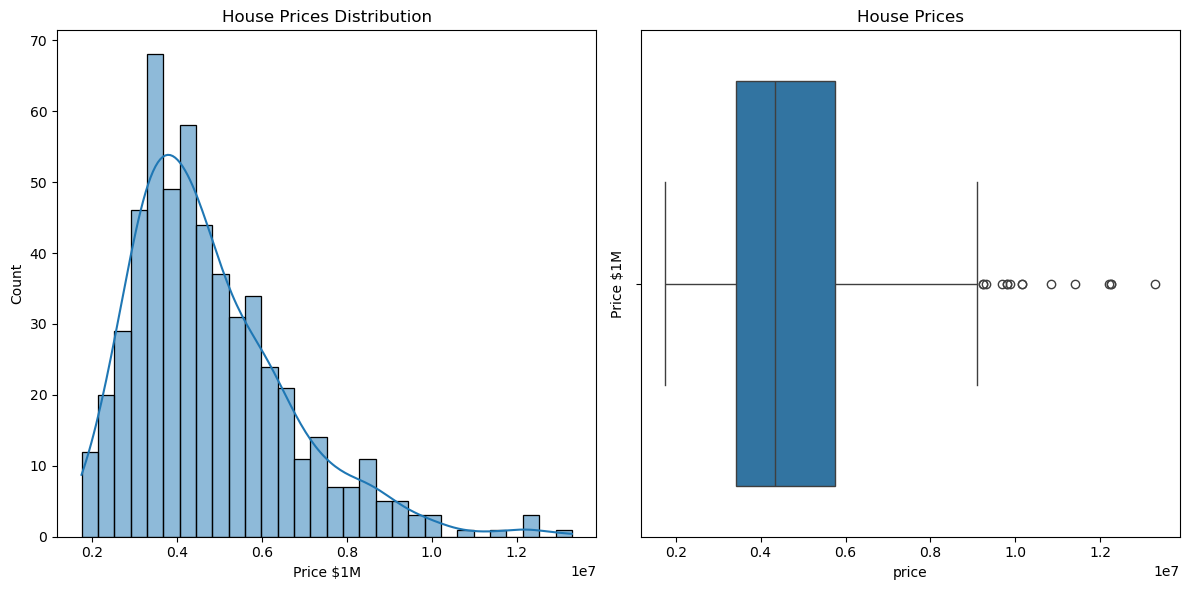

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot - Histogram with KDE
sns.histplot(housing['price'], bins=30, kde=True, ax=axs[0])
axs[0].set_title('House Prices Distribution')
axs[0].set_xlabel('Price $1M')

# Second plot - Boxplot
sns.boxplot(x='price', data=housing, ax=axs[1])
axs[1].set_title('House Prices')
axs[1].set_ylabel('Price $1M')

plt.tight_layout()  # adjusts the spacing of histograms
plt.show()

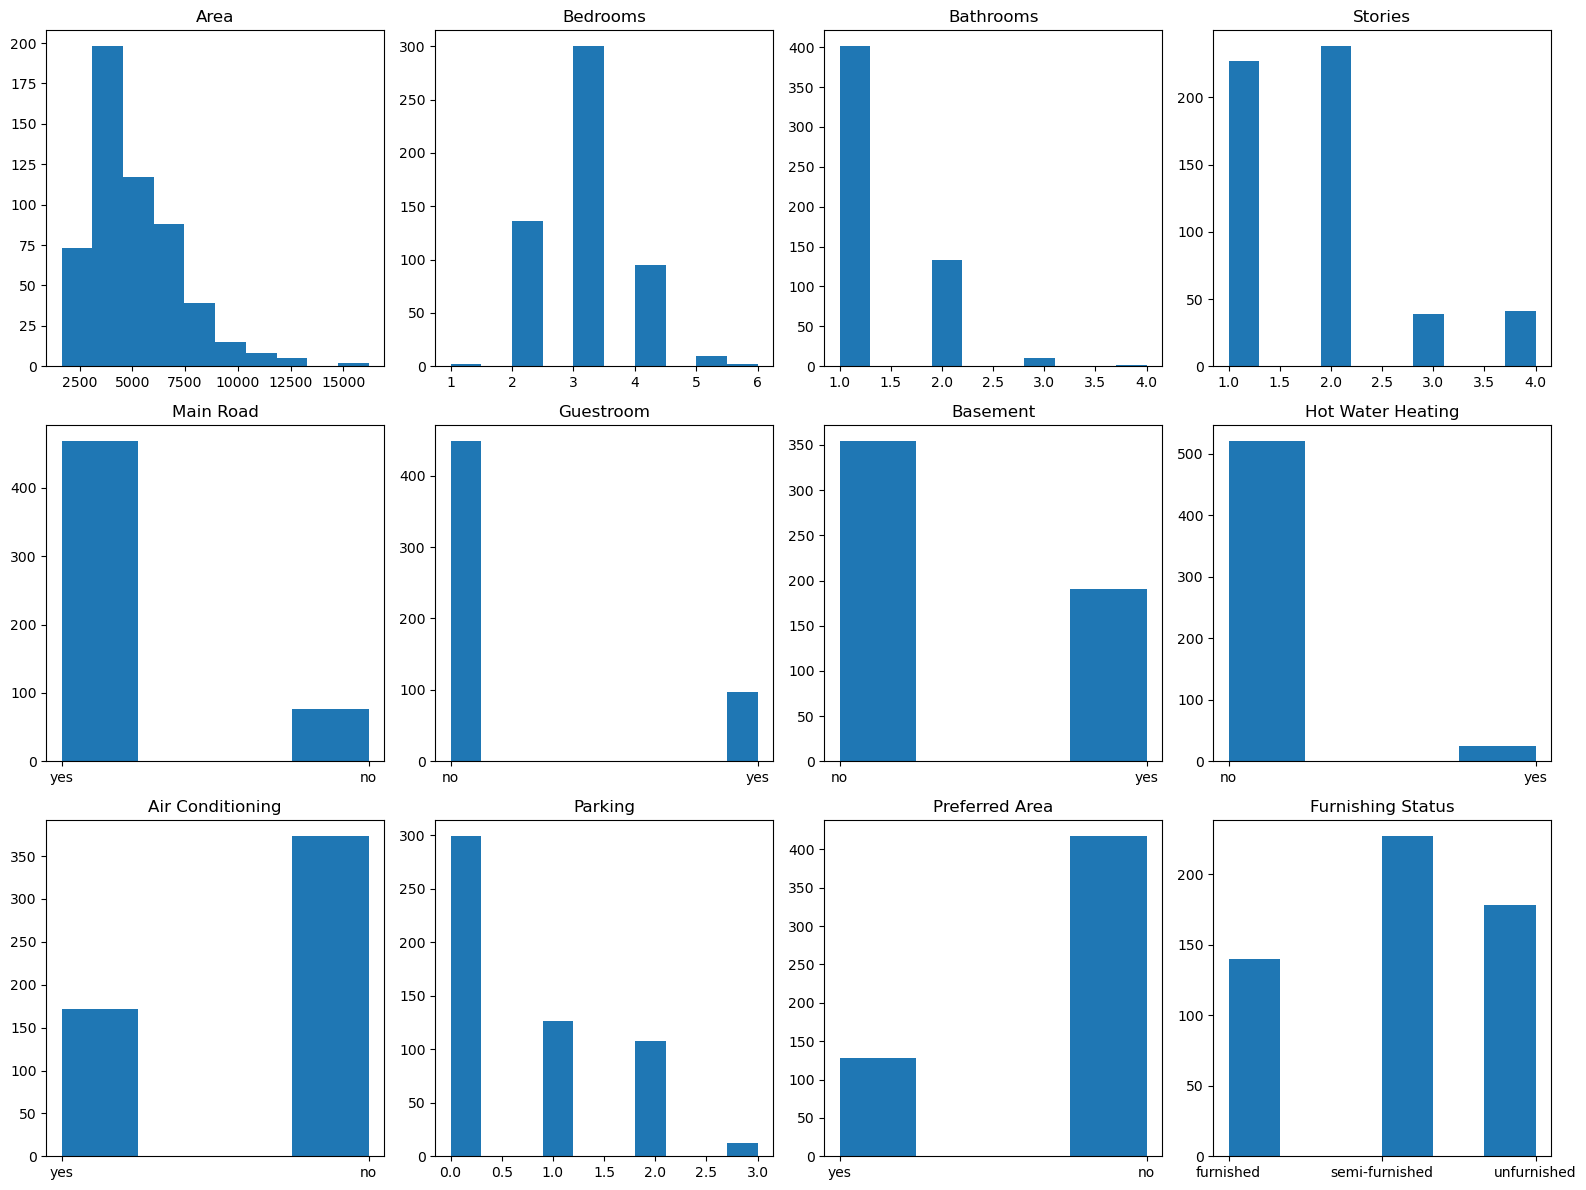

In [9]:
def create_histogram(ax, data, title, bins):
    ax.hist(data, bins=bins)
    ax.set_title(title)

fig, axs = plt.subplots(3, 4, figsize=(16, 12)) # create a 3x4 grid for 12 variables

plots_info = [ # list of column names, titles, and number of bins for each plot
    ('area', 'Area', 10),
    ('bedrooms', 'Bedrooms', 10),
    ('bathrooms', 'Bathrooms', 10),
    ('stories', 'Stories', 10),
    ('mainroad', 'Main Road', 4),
    ('guestroom', 'Guestroom', 10),
    ('basement', 'Basement', 4),
    ('hotwaterheating', 'Hot Water Heating', 4),
    ('airconditioning', 'Air Conditioning', 4),
    ('parking', 'Parking', 10),
    ('prefarea', 'Preferred Area', 4),
    ('furnishingstatus', 'Furnishing Status', 6)
]

for i, (column, title, bins) in enumerate(plots_info): # loop through plots_info and axs to create the histograms
    row, col = divmod(i, 4)  # Calculate row and column indices
    create_histogram(axs[row, col], housing[column], title, bins)

plt.tight_layout() # adjusts layout for better spacing
plt.show() # display the plots

In [10]:
mappings = { # dictionary of mappings for categorical values
    'yes': 1,
    'no': 0,
    'furnished': 2,
    'semi-furnished': 1,
    'unfurnished': 0
}

binary_columns = ['mainroad', # columns needing mapping
                  'guestroom', 
                  'basement', 
                  'hotwaterheating', 
                  'airconditioning', 
                  'parking', 
                  'prefarea']

housing[binary_columns] = housing[binary_columns].replace(mappings).astype(int) # apply mapping
housing['furnishingstatus'] = housing['furnishingstatus'].replace(mappings).astype(int) # apply the mapping for furnishingstatus column

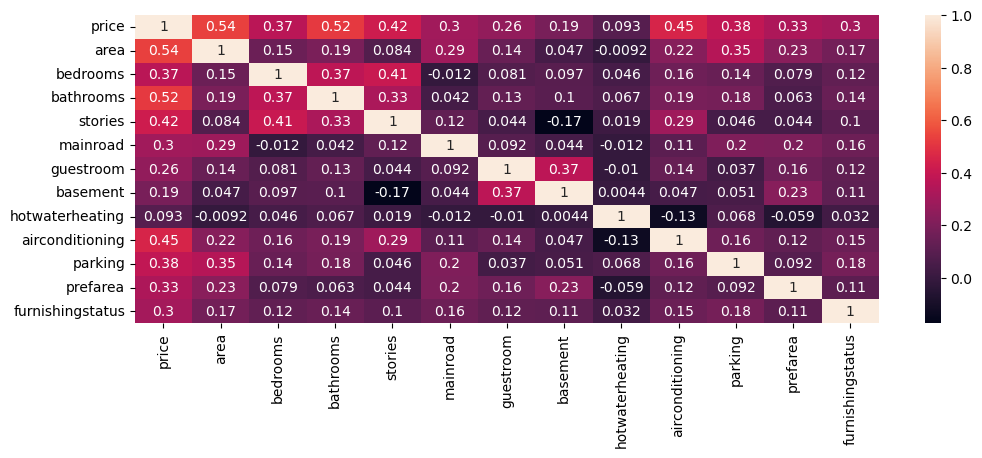

price               1.000000
area                0.535997
bathrooms           0.517545
airconditioning     0.452954
stories             0.420712
parking             0.384394
bedrooms            0.366494
prefarea            0.329777
furnishingstatus    0.304721
mainroad            0.296898
guestroom           0.255517
basement            0.187057
hotwaterheating     0.093073
Name: price, dtype: float64

In [11]:
# build a correlation matrix
corr_matrix = housing.corr()

fig, ax = plt.subplots(figsize=(12,4))        
sns.heatmap(corr_matrix, annot=True)
plt.show()

corr_matrix = corr_matrix['price'].sort_values(ascending=False)
display(corr_matrix)

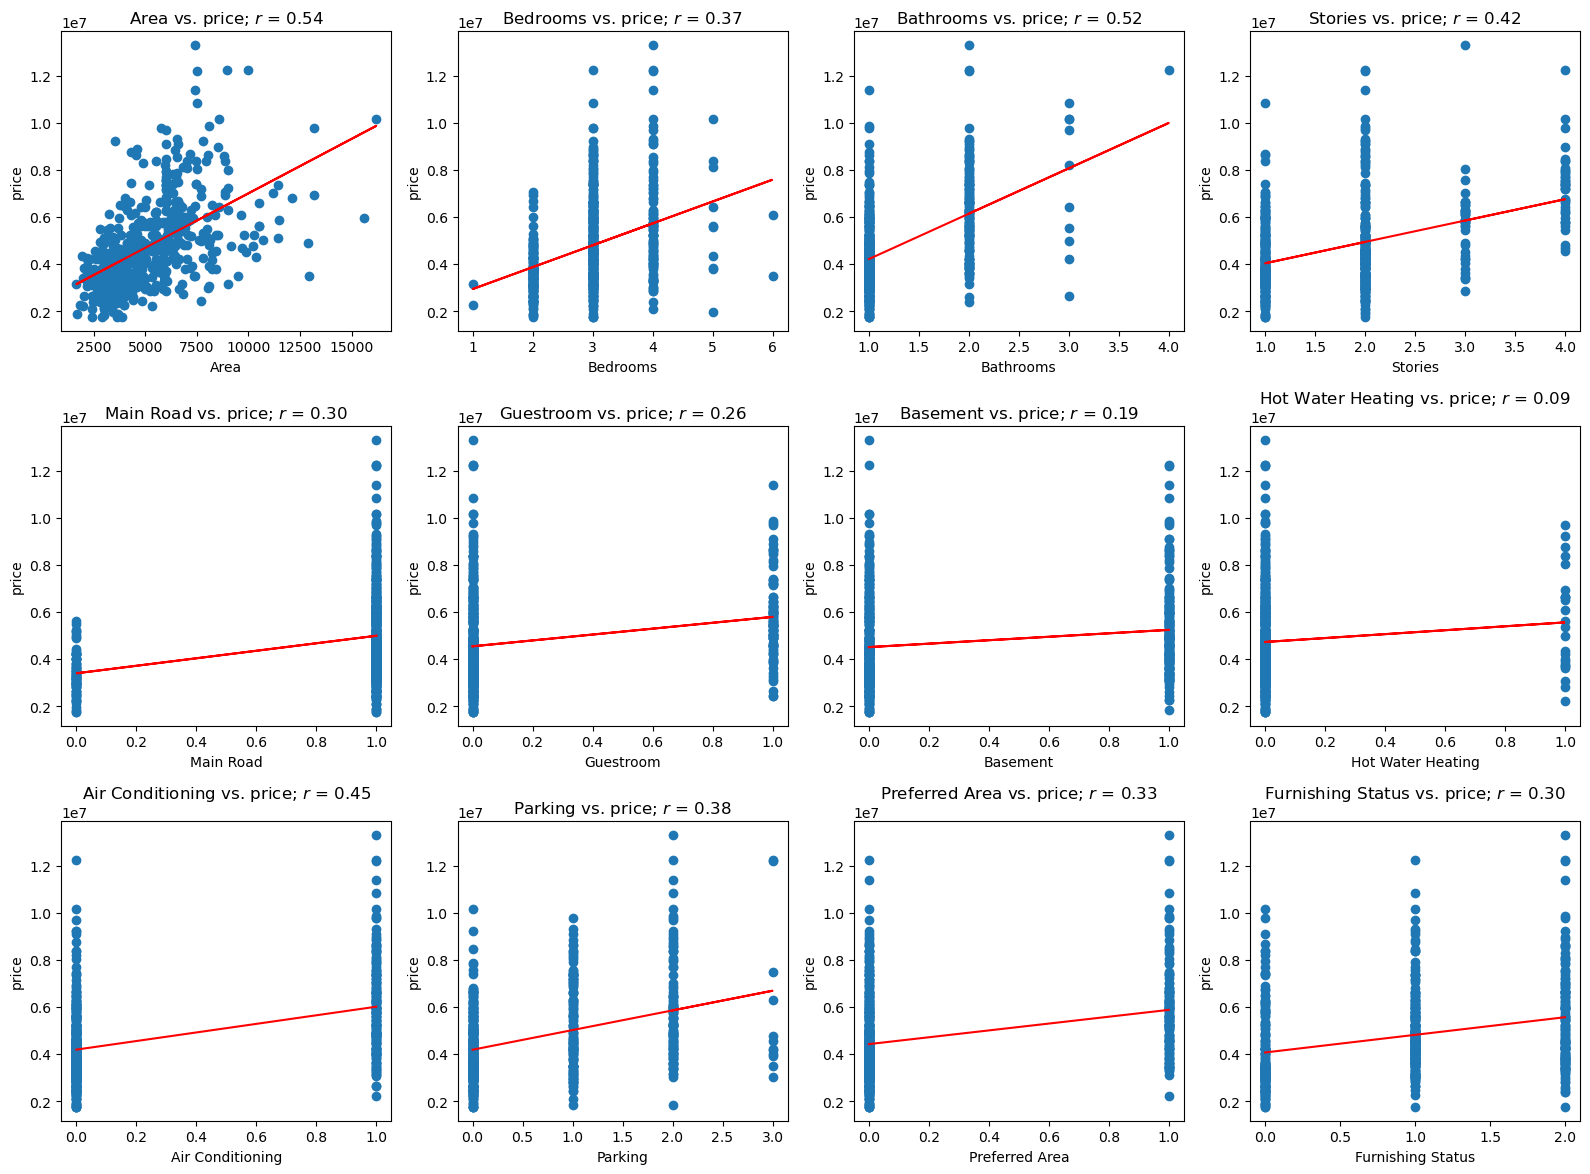

In [12]:
# function to create scatter plots with correlation and regression line
def create_scatterplot(ax, df, x_col, y_col, title):
    m, b = np.polyfit(df[x_col], df[y_col], 1) # get linear regression
    ax.scatter(df[x_col], df[y_col]) # scatter plot
    ax.plot(df[x_col], m * df[x_col] + b, color='red') # plot the regression line
    corr = round(np.corrcoef(df[x_col], df[y_col])[0, 1], 2)# get correlation coefficient
    ax.set_title(f'{title} vs. {y_col}; $\\mathit{{r}}$ = {corr:.2f}')     # set the title with correlation coefficient
    ax.set_xlabel(title)  # set x and y labels
    ax.set_ylabel(y_col)

# create scatter plots for each variable in plots_info
def plot_correlation_grid(df, y_col, plots_info):
    fig, axs = plt.subplots(3, 4, figsize=(16, 12)) # create a 3x4 grid for the scatter plots
    for i, (x_col, title, _) in enumerate(plots_info): # loop through plots_info and axs to create scatter plots with correlation
        row, col = divmod(i, 4)  # Calculate row and column indices
        create_scatterplot(axs[row, col], df, x_col, y_col, title)
    plt.tight_layout()  # ddjust layout for better spacing
    plt.show()  # display the plots

y_col = 'price' # y_col
plot_correlation_grid(housing, y_col, plots_info) # call the function with your DataFrame and the list of variables


# Data Preprocessing

In [13]:

# define features 
X = housing.drop(columns=['price']) # With everything. ~ R-Squared = 0.7
# X = housing[[      #TODO: Pick the ones that perform best...
#             'area', 
#             'bathrooms', 
#             'airconditioning', 
#             'stories', 
#             'parking', 
#             'bedrooms',
#             'prefarea', 
#             'furnishingstatus', 
#             'mainroad', 
#             'guestroom',
#             'basement', 
#             'hotwaterheating'
#         ]]

y = housing['price'] # define dependent variable

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

# Modeling OLS

In [14]:

X_train_ols = sm.add_constant(X_train)  # adding a constant term for OLS
X_test_ols = sm.add_constant(X_test)

# train the OLS model
ols_model = sm.OLS(y_train, X_train_ols).fit()

# make predictions
ols_predictions = ols_model.predict(X_test_ols)

# Model Evaluation OLS

In [15]:

# print OLS summary
print(ols_model.summary())

# OLS Performance Metrics
ols_mae = mean_absolute_error(y_test, ols_predictions)
ols_rmse = np.sqrt(mean_squared_error(y_test, ols_predictions))
ols_r2 = r2_score(y_test, ols_predictions)

print(f"\nOLS - MAE: {ols_mae}, RMSE: {ols_rmse}, R-squared: {ols_r2}")

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     69.15
Date:                Sun, 13 Oct 2024   Prob (F-statistic):           1.51e-86
Time:                        20:21:12   Log-Likelihood:                -5797.6
No. Observations:                 381   AIC:                         1.162e+04
Df Residuals:                     368   BIC:                         1.167e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2.719e+05   2.66e+05  

#  Model Visualization OLS

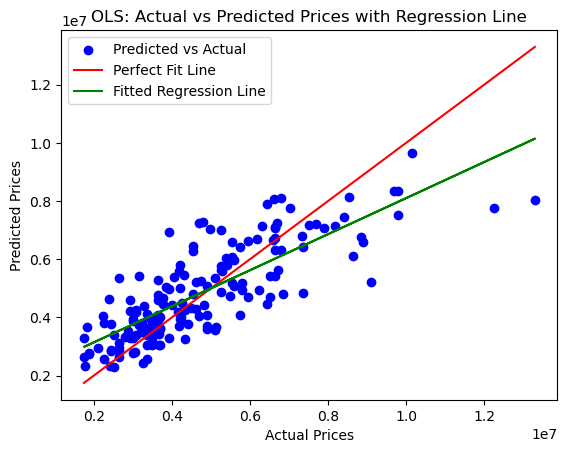

In [23]:
# Scatter plot of actual vs predicted prices from the OLS model
plt.scatter(y_test, ols_predictions, color='blue', label='Predicted vs Actual')  # Use OLS predictions

# Adding a perfect fit line (y = x)
line = np.linspace(min(y_test), max(y_test), 100)
plt.plot(line, line, color='red', label='Perfect Fit Line')

# Fitting the regression line to the actual vs predicted values
regression_line = np.polyfit(y_test, ols_predictions, 1)  # Fit line based on OLS predictions
plt.plot(y_test, np.polyval(regression_line, y_test), color='green', label='Fitted Regression Line')

# Adding labels, title, and legend
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("OLS: Actual vs Predicted Prices with Regression Line")
plt.legend()
plt.show()


# Conclusion

In [17]:

print(f'Our Linear Regression model achieved an R-Squared of {ols_model.rsquared}, which suggests that it explains {(ols_model.rsquared * 100):.0f}% of the variance in housing prices.') 

Our Linear Regression model achieved an R-Squared of 0.6927795109061217, which suggests that it explains 69% of the variance in housing prices.


#  Appendix

# Modeling Gamma

In [18]:
X_train_glm = X_train_ols
X_test_glm = X_test_ols

glm_model = sm.GLM(y_train, X_train_glm, family=sm.families.Gamma()).fit()

# make predictions
glm_predictions = glm_model.predict(X_test_glm)

# Model Evaluation Gamma

In [22]:
print(glm_model.summary())

null_deviance = glm_model.null_deviance
residual_deviance = glm_model.deviance
pseudo_r_squared = 1 - (residual_deviance / null_deviance)

print(f"\nNull Deviance: {null_deviance}") # deviance of the null model (only an intercept)
print(f"Residual Deviance: {residual_deviance}\n") # the deviance of your fitted model (including variables)
print(f'{null_deviance} -> {residual_deviance}: This substantial reduction in deviance suggests that the model is capturing a significant portion of the variability')


glm_mae = mean_absolute_error(y_test, glm_predictions)
glm_rmse = np.sqrt(mean_squared_error(y_test, glm_predictions))
glm_r2 = r2_score(y_test, glm_predictions)

print(f"GLM - MAE: {glm_mae}, RMSE: {glm_rmse}, R²: {glm_r2}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  price   No. Observations:                  381
Model:                            GLM   Df Residuals:                      368
Model Family:                   Gamma   Df Model:                           12
Link Function:           InversePower   Scale:                        0.041627
Method:                          IRLS   Log-Likelihood:                -5760.7
Date:                Sun, 13 Oct 2024   Deviance:                       15.025
Time:                        20:21:24   Pearson chi2:                     15.3
No. Iterations:                     9   Pseudo R-squ. (CS):             0.8741
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             4.335e-07   1.23e-08  

# Model Visualization Gamma

In [20]:

# scatter Plot of Actual vs Predicted Values
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')

# add a regression line based on predicted values
line = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, np.polyval(line, y_test), color='green', label='Fitted Regression Line')

# add the perfect fit line (y = x)
perfect_line = np.linspace(min(y_test), max(y_test), 100)
plt.plot(perfect_line, perfect_line, color='red', label='Perfect Fit Line')

# labels and title
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Gamma GLM: Actual vs Predicted Prices")
plt.legend()
plt.show()

NameError: name 'y_pred' is not defined

# Conclusion

In [ ]:




print(f"OLS - MAE: {ols_mae}, RMSE: {ols_rmse}, R²: {ols_r2}")

# GLM Performance Metrics
glm_mae = mean_absolute_error(y_test, glm_predictions)
glm_rmse = np.sqrt(mean_squared_error(y_test, glm_predictions))
glm_r2 = r2_score(y_test, glm_predictions)

print(f"GLM - MAE: {glm_mae}, RMSE: {glm_rmse}, R²: {glm_r2}")


----------------
$^{1}$ Harishkumar Datalab. (2022). Housing price prediction. Kaggle. https://www.kaggle.com/datasets/harishkumardatalab/housing-price-prediction